In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time 
import random
from qulacs import QuantumState
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix
from qulacs.circuit import QuantumCircuitOptimizer

# ガチで理解する 実践編２

　これまで、様々なアプローチで量子コンピュータを眺めてきた。まず最初に、c言語による簡単な実装によってその仕組みを理解した。そして、従来コンピュータ上のシミュレーションではなく、実機をもちいて量子計算を実行する方法もみてきた。さらに、SymPyをもちいて、形式的な計算がどのように記述されて実行されるかをみて、量子アルゴリズムの仕組みをみた。そして、NumPyをもちいて量子コンピュータのシミュレーションをしながら、量子古典ハイブリッドアルゴリズムを実際に動かしてみた。〜〜で解説されているように、IBMやGoogle、そしてRigetti computingなど量子コンピュータのベンダーたちが開発環境やシミュレータを提供している。なかなか、実機を利用することはできないので、当面は、従来コンピュータ上のシミュレータ環境を用いてアプリケーション探索がおこなわれていくことになる。ここでは、従来コンピュータを用いてどの程度まで量子コンピュータをシミュレーションできるが、現在、世界的にもほぼ最高速のシミュレーション環境を用いてベンチマークしてみたい。

### NumPyで行列を愚直に実装した場合

　まず、〜編でNumPyで構築したシミュレータでベンチマークをとってみよう。

In [3]:
import numpy as np
#パウリ演算子
pI = np.array([[1+0.0j,0+0.0j],[0+0.0j,1+0.0j]])
pX = np.array([[0+0.0j,1+0.0j],[1+0.0j,0+0.0j]])
pZ = np.array([[1+0.0j,0+0.0j],[0+0.0j,-1+0.0j]])
pY = np.array([[0+0.0j,-1.0j],[0.0+1.0j,0.0+0.0j]])
pHad = (pX+pZ)/np.sqrt(2)
pP0 = (pI+pZ)/2
pP1 = (pI-pZ)/2

def define_OneQubitGate(nqubits):    
    global X,Y,Z,H,P0,P1,Ide
    X=[1]*(nqubits)
    Y=[1]*(nqubits)
    Z=[1]*(nqubits)
    H=[1]*(nqubits)
    P0=[1]*(nqubits)
    P1=[1]*(nqubits)

    for i in range(nqubits):
        for j in range(nqubits):
            if(i != j):
                X[i] = np.kron(pI,X[i])
                Y[i] = np.kron(pI,Y[i])
                Z[i] = np.kron(pI,Z[i])
                H[i] = np.kron(pI,H[i])
                P0[i] = np.kron(pI,P0[i])
                P1[i] = np.kron(pI,P1[i])
            else:
                X[i] = np.kron(pX,X[i])
                Y[i] = np.kron(pY,Y[i])
                Z[i] = np.kron(pZ,Z[i])
                H[i] = np.kron(pHad,H[i])
                P0[i] = np.kron(pP0,P0[i])
                P1[i] = np.kron(pP1,P1[i])
    Ide = np.eye(2**nqubits)

def define_TwoQubitGate(nqubits):
    global CZ,CX
    CZ = [[0 for i in range(nqubits)] for j in range(nqubits)]
    CX = [[0 for i in range(nqubits)] for j in range(nqubits)]

    for i in range(nqubits):
        for j in range(nqubits):
            CZ[i][j]= (P0[i]+np.dot(P1[i],Z[j]))
            CX[i][j]= (P0[i]+np.dot(P1[i],X[j]))
            
def StateZeros(nqubits):
    State = np.zeros(2**nqubits)
    State[0]=1
    return State

In [12]:
import time
bench_result=[[],[]]

for i in range(6):
    nqubits = i+5
    define_OneQubitGate(nqubits)
    define_TwoQubitGate(nqubits)


    state = StateZeros(nqubits)
    count = 0
    
    #計測スタート
    start = time.time()
    while time.time() - start < 1:
        count = count+1
        for j in range(nqubits):
            state = np.dot(H[j],state) #H演算の速度を計測
    elapsed_time = (time.time() - start)/count
    #計測終了
    bench_result[0].append(nqubits)    
    bench_result[1].append(elapsed_time)
    
    print ("number of qubit:{0}".format(nqubits)+" time:{0}".format(elapsed_time) + "[sec]")

number of qubit:5 time:8.392826229196309e-06[sec]
number of qubit:6 time:3.127821034966341e-05[sec]
number of qubit:7 time:0.00011879223403178509[sec]
number of qubit:8 time:0.000561844961218858[sec]
number of qubit:9 time:0.0020691382983499323[sec]
number of qubit:10 time:0.015797503292560577[sec]


<function matplotlib.pyplot.show>

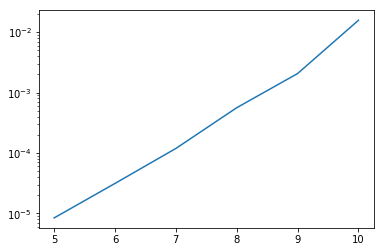

In [13]:
import matplotlib.pyplot as plt
plt.yscale("log")
plt.plot(bench_result[0],bench_result[1])
plt.show

量子ビット数に対して計算時間がきれいに指数的にスケールしていることがわかる。2量子ビット演算（CNOT）についてもベンチマークを取っておこう

In [10]:
bench_result=[[],[]]

for i in range(6):
    nqubits = i+5
    define_OneQubitGate(nqubits)
    define_TwoQubitGate(nqubits)

    state = StateZeros(nqubits)
    count = 0
    
    #計測スタート
    start = time.time()
    while time.time() - start < 1:

        for j in range(nqubits):
            for k in range(nqubits):
                if j != k:
                    count = count+1
                    state = np.dot(CX[j][k],state) #H演算の速度を計測
    elapsed_time = (time.time() - start)/count
    #計測終了
    
    bench_result[0].append(nqubits)    
    bench_result[1].append(elapsed_time)
    
    print ("number of qubit:{0}".format(nqubits)+" time:{0}".format(elapsed_time) + "[sec]")

number of qubit:5 time:2.1286287831468448e-06[sec]
number of qubit:6 time:5.455034253484915e-06[sec]
number of qubit:7 time:2.485619347088031e-05[sec]
number of qubit:8 time:7.988113377775465e-05[sec]
number of qubit:9 time:0.00033584126719722043[sec]
number of qubit:10 time:0.0014906750784979927[sec]


<function matplotlib.pyplot.show>

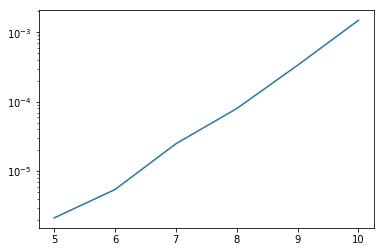

In [11]:
import matplotlib.pyplot as plt
plt.yscale("log")
plt.plot(bench_result[0],bench_result[1])
plt.show

２量子ビット演算についても綺麗に指数スケールしている。11量子ビットの実行時には約5GBのメモリーを消費していた。これは、ここでNumPyを用いた実装では、演算を行列として確保してしまうため、量子ビットの数 $n$ に対して、$2^n \times 2^n$の行列を、$O(n)$個も定義してしまっているためだ。倍精度で、64bit 、複素数なので、さらに２倍、128bit = 16 Byte のメモリを１つの複素数で消費するので、n=11で、$n*2^{2n} = 11*4*10^6$個の複素数、といった感じでだいたい計算があう。

### 高速シミュレータ、Qulacsを使ってみる

　量子演算の実行にはかならずしも、演算を行列として確保する必要はないので、もっとメモリを節約して計算をすることができる。実際、〜章で紹介したc言語の実装は状態ベクトルのみを更新していった。こういう設計原理にもとづくと、計算の並列化も容易になる。ここでは、最近我々の研究室（技術補佐員及び多くの有志の貢献者）で開発し、現在私も技術顧問として参画する量子コンピュータのソフトウェアベンチャー企業である （株）QunaSys に技術移転しサポートしているオープンソースの量子コンピュータ高速シミュレータ、Qulacs (http://qulacs.org/index.html, https://github.com/qulacs/qulacs)を導入しながら、ベンチマークをとってみよう。

 Qulacsは、pythonから利用することができ
```
pip instal qulacs
```
でインストールすることができる。実装は、C言語およびC++言語を使い、gccのopenMPを用いて高速化している。
このため、gcc-7, g++-7を必要とする。macユーザーの場合は、Xcodeからgccとg++を利用することができるが、デフォルトではclangが動いているので、brew等でgcc-7をインストールしておこう。qulacsのインストールの詳しい手続きは、
```
http://qulacs.org/md_1__how_to_install.html
```
を参考にしていただきたい。


### 量子ビットの確保
　$n$個の量子ビットの状態を表現するためには、$2^n$個の要素からなる複素ベクトルを準備する必要がある。量子状態に関数さまざまな関数は、`QuantumState`モジュールを用いて実行することができる。`QuantumState(n)`で量子ビット数nを指定して、状態を確保することができる。

In [14]:
from qulacs import QuantumState
import matplotlib.pyplot as plt

In [15]:
nqubits = 10
state = QuantumState(nqubits)

また、確保した量子ビットをすべて0状態、$|00...0\rangle$へと初期化は `set_zero_state()`で行うことができる。

In [16]:
state.set_zero_state()

量子状態を取得し、`array`として格納するには、`get_vector()`を使う。

In [17]:
state_array = state.get_vector()
print(state_array)

[1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]


ゼロ状態への初期化以外にも、ビット列を指定した初期化、`set_computational_basis()`、や、ランダムな量子状態の準備、`set_Haar_random_state()`、などの準備を行う関数も用意されている。

In [18]:
state.set_computational_basis(0b1010110100)
print(state.get_vector()[0b1010110100])

(1+0j)


In [19]:
seed = 0
state.set_Haar_random_state(seed)
state_array = state.get_vector()
print(state.get_vector())

[ 0.01569934+0.01098499j  0.02473238-0.0177075j   0.01921624-0.00417593j
 ... -0.00787774-0.00455164j -0.02102754+0.02898774j
  0.01793351+0.01315451j]


確率分布を計算し、大きい順にならべてプロットすると、

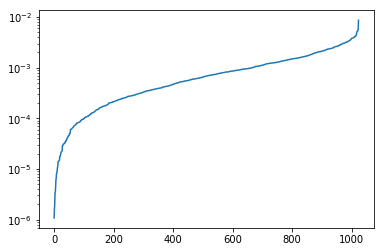

In [20]:
prob =[0]*(2**nqubits)
for i in range(2**nqubits):
    prob[i]=abs(state_array[i])**2

plt.yscale("log")
plt.plot(np.sort(prob))

のようになっており、単なる一様分布（prob[i]=$1/2^10$）とは全く異なる分布、ポーター・トーマス分布とよばれるになっている。

　量子状態のために確保したメモリの解放は、`del`から行うことができる。

In [21]:
del state
state

NameError: name 'state' is not defined

qulacsには他にも、量子状態のコピーや、

In [22]:
state = QuantumState(nqubits)
copied_state = state.copy()

２つの量子状態の内積の計算、

In [26]:
from qulacs.state import inner_product
inner_product(copied_state,state)
#同じ状態の内積なので1になる。

(1+0j)

そして、古典ビットの確保など、他にもさまざまな機能が用意されている。

### 量子演算とその実行

　量子演算の生成は、`gate`に関するモジュールを用いて実行する。パウリ演算やアダマール演算、CNOT演算など、よく使う基本演算はあらかじめ定義されている。また、自分で定義した配列から、量子演算を生成することもできる。

In [27]:
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H,S,Sdag, sqrtX,sqrtXdag,sqrtY,sqrtYdag #1量子ビット Clifford演算
from qulacs.gate import T,Tdag #1量子ビット 非Clifford演算
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算
from qulacs.gate import CNOT, CZ, SWAP #2量子ビット演算

`Identity` $
=
\left(
\begin{array}{cc}
1 & 0
\\
0 & 1
\end{array}
\right)
$, 
`X` $
= 
\left(
\begin{array}{cc}
0 & 1
\\
1 & 0
\end{array}
\right)
$, 
`Y` $
=
\left(
\begin{array}{cc}
0 & -i
\\
i & 0
\end{array}
\right)
$, 
`Z` $
=
\left(
\begin{array}{cc}
1 & 0
\\
0 & -1
\end{array}
\right)
$, 


`H` $
=
\frac{1}{\sqrt{2}}\left(
\begin{array}{cc}
1 & 1
\\
1 & -1
\end{array}
\right)
$, 
`S` $
=
\left(
\begin{array}{cc}
1 & 0
\\
0 & i
\end{array}
\right)
$,
`Sdag` $
=
\frac{1}{\sqrt{2}}\left(
\begin{array}{cc}
1 & 0
\\
0 & -i
\end{array}
\right)
$,


`sqrtX` $
=\sqrt{X}=
\frac{1}{2}\left(
\begin{array}{cc}
1+i & 1-i
\\
1-i & 1+i
\end{array}
\right)
$, 
`sqrtXdag` $
=\sqrt{X}^{\dagger}=
\frac{1}{2}\left(
\begin{array}{cc}
1-i & 1+i
\\
1+i & 1-i
\end{array}
\right)
$, 

`sqrtY` $
=\sqrt{Y}=
\frac{1}{2}\left(
\begin{array}{cc}
1+i & -1-i
\\
1+i & 1+i
\end{array}
\right)
$, 
`sqrtYdag` $
=\sqrt{Y}^{\dagger}=
\frac{1}{2}\left(
\begin{array}{cc}
1-i & -1+i
\\
1-i & 1-i
\end{array}
\right)
$

`T` 
$
= 
\left(
\begin{array}{cc}
1 & 0
\\
0 & e^{i \pi/4}
\end{array}
\right)
$, 
`Tdag` 
$=
\left(
\begin{array}{cc}
1 & 0
\\
0 & e^{-i \pi/4}
\end{array}
\right)
$


`RX` $= e^{i \theta X}$, `RY` $= e^{i \theta Y}$, `RZ` $= e^{i \theta Z}$

`CNOT` $= \left(
\begin{array}{cccc}
    1 & 0& 0& 0
    \\
    0 & 1& 0& 0
    \\
    0 & 0& 0& 1
    \\
    0 & 0& 1& 0    
\end{array}
\right)
$,
`CZ` $= \left(
\begin{array}{cccc}
    1 & 0& 0& 0
    \\
    0 & 1& 0& 0
    \\
    0 & 0& 1& 0
    \\
    0 & 0& 0& -1    
\end{array}
\right)
$,
`SWAP` $= \left(
\begin{array}{cccc}
    1 & 0& 0& 0
    \\
    0 & 0& 1& 0
    \\
    0 & 1& 0& 0
    \\
    0 & 0& 0& 1    
\end{array}
\right)
$

他にも、多体のパウリ演算、`Pauli`、多体パウリ演算による回転、`PauliRotation`、IBMQで利用されている`U1`,`U2`,`U3`演算や、測定、`Measurement`、ノイズ（確率的な演算）、 `BitFlipNoise`、`DephasingNoise`、 `IndepenedentXZNoise`、`DepolarizingNoise`なども用意されている。これらの事前に定義された演算に対して、量子ビットのインデックスや、回転演算の角度など必要な情報を引数として指定することによってが`gate`が生成される。生成された演算を状態に作用させ状態`state`を更新するときは、`gate.update_quantum_state(state)`が利用できる。

In [29]:
state = QuantumState(3) #量子ビットの状態確保
state.set_zero_state() #状態をすべてゼロに初期化
print(state.get_vector()) #状態の情報を取得

X(0).update_quantum_state(state) #0番目の量子ビットにXを作用させ状態をアップデート
print(state.get_vector())

gate = X(1) #1番目の量子ビットに作用するX演算を生成
gate.update_quantum_state(state) #生成した演算を作用させて状態をアップデート
print(state.get_vector())

H(2).update_quantum_state(state) #2番目の量子ビットにHを作用させ状態をアップデート
print(state.get_vector())

CNOT(2,1).update_quantum_state(state) #2番目から1番目の量子ビットへのCNOTを作用させ状態をアップデート
print(state.get_vector())

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
[0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j
 0.        +0.j 0.70710678+0.j 0.        +0.j 0.        +0.j]


`RX`、`RY`,`RZ`などの回転演算は、作用する量子ビットのインデックスと回転角を与えて定義する。

In [30]:
state = QuantumState(1)
state.set_zero_state()
RY(0,np.pi/4.0).update_quantum_state(state) #0番目の量子ビットをY軸に pi/4 回転させる
print(state.get_vector())

[ 0.70710678+0.j -0.70710678+0.j]


`DenseMatrix`を用いて、自分で定義した一般の行列から演算を作ることもできる。

In [31]:
from qulacs.gate import DenseMatrix
import numpy as np
state = QuantumState(1)
state.set_zero_state()
H(0).update_quantum_state(state)

my_matrix = np.array([[0,12345*np.sqrt(2)],[98765*np.sqrt(2),0]]) #任意の行列要素を自分で定義
print(my_matrix)

gate = DenseMatrix(0,my_matrix) #定義した行列から演算を生成
gate.update_quantum_state(state)

print(state.get_vector())

[[     0.          17458.4664275 ]
 [139674.80248778      0.        ]]
[12345.+0.j 98765.+0.j]


複数の量子ビットに作用する演算を定義したければ、`DenseMatrix("作用する量子ビットのインデックスリスト","行列の配列")`とすればよい。

### 量子回路の構成

上で説明したように、各演算ごとに実行して量子状態を更新することもできるが、複雑な量子回路を構成する場合には、実行する前に量子回路を構成できると便利であろう。qulacsでは、`QuantumCircuit`を用いて、演算の集合からなる回路`circuit`を定義することができる。定義した回路をprintすると、構成された回路の詳細データを得ることができる。

In [32]:
from qulacs import QuantumCircuit
nqubits = 2
state = QuantumState(nqubits)
state.set_zero_state()
circuit = QuantumCircuit(nqubits)
print(circuit)

*** Quantum Circuit Info ***
# of qubit: 2
# of step : 0
# of gate : 0
Clifford  : yes
Gaussian  : yes




回路への、演算の追加は、以下のような方法で行うことができる。

In [33]:
circuit.add_H_gate(0) # 0番目の量子ビットに作用するHを追加
circuit.add_gate(H(1)) # 1番目の量子ビットに作用するHを追加
print(circuit)

*** Quantum Circuit Info ***
# of qubit: 2
# of step : 1
# of gate : 2
# of 1 qubit gate: 2
Clifford  : yes
Gaussian  : no




このようにして構成された`circuit`を実行して`state`の更新を行いたければ、`gate`の場合と同様に、
`circuit.update_quantum_state(state)`とすればよい。

In [34]:
circuit.update_quantum_state(state) #構成されたcircuitを実行して状態を更新
print(state.get_vector())

[0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]


### Qulacsのベンチマーク
    一通り、導入が終わったので、qulacsの実行速度を計測してみよう。まずは、一量子ビットの実行時間を計測してみる。

In [35]:
import time
bench_result_H=[[],[]]

for i in range(21):
    nqubits = i+5
    state = QuantumState(nqubits)
    state.set_zero_state()
    circuit = QuantumCircuit(nqubits)
    for j in range(nqubits):
        circuit.add_gate(H(j)) #全部の量子ビットにHを作用させる回路を構成
    
    count = 0
    
    #計測スタート
    start = time.time()
    while time.time() - start < 1:
        count = count+1
        circuit.update_quantum_state(state)
    elapsed_time = (time.time() - start)/(count*nqubits)
    #計測終了
    
    total_counts = count*nqubits
    bench_result_H[0].append(nqubits)    
    bench_result_H[1].append(elapsed_time)
    
    print ("number of qubit:{0}".format(nqubits)+" time:{0}".format(elapsed_time) + "[sec]")

number of qubit:5 time:4.6547229883142036e-05[sec]
number of qubit:6 time:4.278063202948704e-05[sec]
number of qubit:7 time:4.211170167141194e-05[sec]
number of qubit:8 time:4.557532374110484e-05[sec]
number of qubit:9 time:4.803270035720543e-05[sec]
number of qubit:10 time:4.7924819036025894e-05[sec]
number of qubit:11 time:4.802082508896825e-05[sec]
number of qubit:12 time:5.222322946801819e-05[sec]
number of qubit:13 time:5.917228890593941e-05[sec]
number of qubit:14 time:7.590980437125135e-05[sec]
number of qubit:15 time:0.00010931147903692526[sec]
number of qubit:16 time:0.00017692624343990606[sec]
number of qubit:17 time:0.00033743890393681886[sec]
number of qubit:18 time:0.0006444105547811184[sec]
number of qubit:19 time:0.0012057979711505215[sec]
number of qubit:20 time:0.0023414790630340576[sec]
number of qubit:21 time:0.004710644354551902[sec]
number of qubit:22 time:0.01073573719371449[sec]
number of qubit:23 time:0.019708232603211334[sec]
number of qubit:24 time:0.040874625

<function matplotlib.pyplot.show>

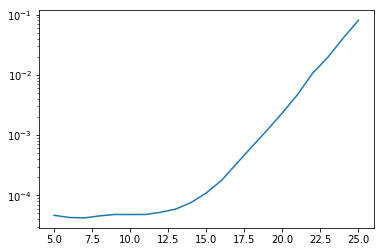

In [36]:
import matplotlib.pyplot as plt
plt.yscale("log")
plt.plot(bench_result_H[0],bench_result_H[1])
plt.show

25量子ビットまで実行してみたが、かなり高速に動くことがわかる。MacBockPro(Intel Core i7 2.5GHz)で実行した場合でも１つの演算あたりの実行時間は、20量子ビットで0.002秒、25量子ビットで0.08秒といったところだ。CNOTについても計測しておこう。

In [37]:
bench_result_CNOT=[[],[]]

for i in range(21):
    nqubits = i+5
    state = QuantumState(nqubits)
    state.set_zero_state()
    circuit = QuantumCircuit(nqubits)
    for j in range(nqubits):
        for k in range(nqubits):
            if k != j :
                circuit.add_gate(CNOT(j,k))        

    count = 0
    
    #計測スタート
    start = time.time()
    while time.time() - start < 1:
        count = count+1
        circuit.update_quantum_state(state)
    elapsed_time = time.time() - start
    #計測終了
    
    total_counts = count*nqubits*(nqubits-1)
    bench_result_CNOT[0].append(nqubits)    
    bench_result_CNOT[1].append(elapsed_time/total_counts)
    
    print ("number of qubit:{0}".format(nqubits)+" time:{0}".format(elapsed_time/total_counts) + "[sec]")

number of qubit:5 time:4.7539066905757776e-05[sec]
number of qubit:6 time:4.664409966457696e-05[sec]
number of qubit:7 time:4.648985243503136e-05[sec]
number of qubit:8 time:4.801704298258284e-05[sec]
number of qubit:9 time:4.434416839102862e-05[sec]
number of qubit:10 time:4.391334396856246e-05[sec]
number of qubit:11 time:4.702062392301837e-05[sec]
number of qubit:12 time:5.772727634843278e-05[sec]
number of qubit:13 time:4.956711678815311e-05[sec]
number of qubit:14 time:6.048779544616117e-05[sec]
number of qubit:15 time:8.407917835359884e-05[sec]
number of qubit:16 time:9.957149971363156e-05[sec]
number of qubit:17 time:0.00019812385548748099[sec]
number of qubit:18 time:0.0003221773775432766[sec]
number of qubit:19 time:0.0006161766442639089[sec]
number of qubit:20 time:0.0009783069292704264[sec]
number of qubit:21 time:0.0018851382391793386[sec]
number of qubit:22 time:0.003654939271670915[sec]
number of qubit:23 time:0.008095686143566027[sec]
number of qubit:24 time:0.0170275668

<function matplotlib.pyplot.show>

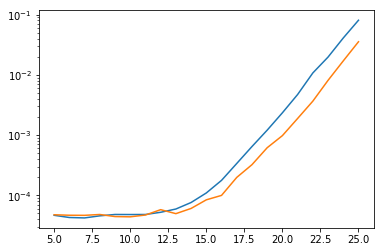

In [38]:
plt.yscale("log")
plt.plot(bench_result_H[0],bench_result_H[1])
plt.plot(bench_result_CNOT[0],bench_result_CNOT[1])
plt.show

1量子ビット演算よりも2量子ビット演算であるCNOTの方が数倍ほど速いことがわかる。これは、CNOTは複素数の積や和を行う必要がなく、特定の要素を置換することによって実行できるからである。qulacsでは事前に定義されている基本演算のうち、このような性質をもった演算についてはその性質を利用して高速化している。一般の２量子ビット演算の場合に計測してみよう。

In [39]:
from qulacs.gate import DenseMatrix

bench_result_TwoQbit=[[],[]]

#ランダムな要素の4×4行列を生成
random_matrix = np.array([[random.random() for i in range(4)] for j in range(4)])

for i in range(21):
    nqubits = i+5
    state = QuantumState(nqubits)
    state.set_zero_state()
    circuit = QuantumCircuit(nqubits)
    for j in range(nqubits):
        for k in range(nqubits):
            if k != j :
                circuit.add_gate(DenseMatrix([k,j],random_matrix))        

    count = 0
    
    #計測スタート
    start = time.time()
    while time.time() - start < 1:
        count = count+1
        circuit.update_quantum_state(state)
    elapsed_time = time.time() - start
    #計測終了
    
    total_counts = count*nqubits*(nqubits-1)
    bench_result_TwoQbit[0].append(nqubits)    
    bench_result_TwoQbit[1].append(elapsed_time/total_counts)
    
    print ("number of qubit:{0}".format(nqubits)+" time:{0}".format(elapsed_time/total_counts) + "[sec]")

number of qubit:5 time:4.633974432392845e-05[sec]
number of qubit:6 time:5.56491253173013e-05[sec]
number of qubit:7 time:5.456118382593899e-05[sec]
number of qubit:8 time:4.994957235843205e-05[sec]
number of qubit:9 time:5.459777669968948e-05[sec]
number of qubit:10 time:5.478757159854783e-05[sec]
number of qubit:11 time:7.431898307377377e-05[sec]
number of qubit:12 time:9.316701582424392e-05[sec]
number of qubit:13 time:0.00012710982677983302[sec]
number of qubit:14 time:0.00019482511062882262[sec]
number of qubit:15 time:0.00039270587893196077[sec]
number of qubit:16 time:0.0007041679488288032[sec]
number of qubit:17 time:0.0013432020650190465[sec]
number of qubit:18 time:0.0024317191317190534[sec]
number of qubit:19 time:0.004573798319052535[sec]
number of qubit:20 time:0.009140147660907946[sec]
number of qubit:21 time:0.019021778447287422[sec]
number of qubit:22 time:0.04223521240861901[sec]
number of qubit:23 time:0.08223334131504707[sec]
number of qubit:24 time:0.155961567077083

<function matplotlib.pyplot.show>

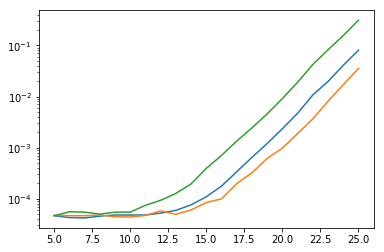

In [40]:
plt.yscale("log")
plt.plot(bench_result_H[0],bench_result_H[1])
plt.plot(bench_result_CNOT[0],bench_result_CNOT[1])
plt.plot(bench_result_TwoQbit[0],bench_result_TwoQbit[1])
plt.show

一般の２量子ビット演算の場合、１量子ビット演算よりも数倍の時間が必要である。上で`DenseMatrix`を用いてランダムな要素をもった２量子ビット演算は、ユニタリ行列ではないので、実際の量子コンピュータの演算にはもはや対応していない。しかし、シミュレータの速度計測のためには十分である。

　量子ビット数を20に固定して、一般的なk量子ビット演算を作用させた場合の時間を計測してみよう。

In [2]:
import numpy as np
from qulacs.gate import DenseMatrix

bench_result_Dense=[[],[]]

nqubits =20
for k in range(1,11):
    dim_of_gate = 2**k
    random_matrix = np.array([[random.random() for i in range(dim_of_gate)] for j in range(dim_of_gate )]) 
    state = QuantumState(nqubits)
    state.set_zero_state()
    circuit = QuantumCircuit(nqubits)
    for j in range(100):
        circuit.add_gate(DenseMatrix(random.sample(range(nqubits),k),random_matrix))        

    count = 0
    
    #計測スタート
    start = time.time()
    while time.time() - start < 1:
        count = count+1
        circuit.update_quantum_state(state)
    elapsed_time = time.time() - start
    #計測終了
    
    total_counts = count*100
    bench_result_Dense[0].append(k)    
    bench_result_Dense[1].append(elapsed_time/total_counts)
    
    print ("size of gate:{0}".format(k)+" time:{0}".format(elapsed_time/total_counts) + "[sec]")

size of gate:1 time:0.0026661455631256104[sec]
size of gate:2 time:0.010079967975616454[sec]
size of gate:3 time:0.010720529556274415[sec]
size of gate:4 time:0.018960270881652832[sec]
size of gate:5 time:0.036492810249328614[sec]
size of gate:6 time:0.07666563987731934[sec]
size of gate:7 time:0.1588979697227478[sec]
size of gate:8 time:0.33669424057006836[sec]
size of gate:9 time:0.7163684391975402[sec]
size of gate:10 time:1.664895899295807[sec]


<function matplotlib.pyplot.show>

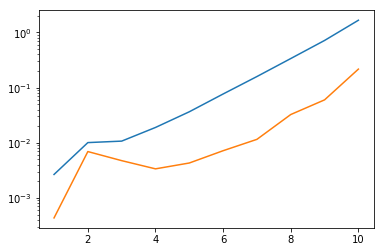

In [3]:
plt.yscale("log")
plt.plot(bench_result_Dense[0],bench_result_Dense[1])
plt.plot(np.loadtxt("Xeon_merge01.txt",unpack=True)[0],np.loadtxt("Xeon_merge01.txt",unpack=True)[1])
plt.show

　量子演算のサイズ（作用する量子ビット数）が４以上になると指数的に計算時間が増えていることがわかる。一方、４未満、とくに２と３では、量子演算サイズが増えてもあまり計算時間が増えていない。これは、小さいサイズの量子演算の場合は、メモリアクセスが計算時間を律速しているためである。量子演算のサイズが大きくなると、メモリアクセスの律速から、CPUでの計算の律速へと移行するため、量子演算のサイズが増えるにつえて指数的に計算時間がかかる。並列度の高いマシンの場合は、CPUの演算能力に対して、メモリの帯域が相対的に小さくなってしまう。実際、Intel(R) Xeon(R) Gold 6154 CPU @ 3.00GHz 18×4=72コア搭載した計算機サーバーでは、メモリアクセスの律速による影響が大きいので、５量子ビットくらいまでは合成しても、計算時間が単純には２倍にはならない。また、core i7 2.5GHzと比べると、４量子ビット演算以上のサイズの演算では約10倍ほど高速に計算ができる。

### 演算の合成による量子回路の再構成

量子演算を実行して量子状態を更新するのは量子ビット数に対して指数的に時間がかかるタスクである。よって、一量子ビットの演算が連続して作用する場合などは、それらをまとめてしまい、１回の更新としてしまったほうがよいであろう。qulacsでは、2つの演算を合成`merge`して１つの演算としてまとめるような機能が実装されている。`merge(gate1,gate2)`とすることで、`gate1`を作用させ、`gate2`をその後作用させるという演算をまとめた一つの演算が生成される。例えば、１量子ビット演算が連続して作用する以下のような場合を考えよう。

In [44]:
#計測スタート
start = time.time()
nqubits =24
state = QuantumState(nqubits)
state.set_zero_state()
circuit = QuantumCircuit(nqubits)
for i in range(nqubits):
    circuit.add_gate(H(i))
    circuit.add_gate(RX(i,np.random.random()))
    circuit.add_gate(RY(i,np.random.random()))
    circuit.add_gate(RZ(i,np.random.random()))
    
circuit.update_quantum_state(state)
elapsed_time = (time.time() - start)
#計測終了
print("not  time:{0}".format(elapsed_time) + "[sec]")


not  time:4.189133882522583[sec]


この複数の1量子ビット演算をまとめて、１つの演算に合成して、状態を更新すると、

In [45]:
from qulacs.gate import merge
#計測スタート
start = time.time()
nqubits =24
state = QuantumState(nqubits)
state.set_zero_state()
circuit = QuantumCircuit(nqubits)
for i in range(nqubits):
    gate = H(i)
    gate = merge(gate,RX(i,np.random.random()))
    gate = merge(gate,RY(i,np.random.random()))
    gate = merge(gate,RZ(i,np.random.random()))
    circuit.add_gate(gate)


circuit.update_quantum_state(state)
elapsed_time = (time.time() - start)
#計測終了
print("not merged  time:{0}".format(elapsed_time) + "[sec]")

not merged  time:1.1644189357757568[sec]


計算時間が約4倍に速くなっている。一般的に、作用する量子ビットが増えない場合は、常に合成したほうが計算時間は短くなる。また、上でベンチマークをとったように、4量子ビットまでは、必ずしも合成しても計算時間が2倍で増えていくわけではないので、作用する量子ビット数を増やしてでも合成してしまうほうが時間短縮される場合もある。

 もう少し、現実的な量子回路で、計算時間の最適化をおこなってみよう。1量子ビットの任意の回転ができる、
$$
V(a,b,c) = e^{i a Z} e^{i b X} e^{i c Z}
$$
を各量子ビットに作用させ、隣り合う量子ビットに `CZ` を作用させるような一連の演算を１つのサイクルとし、これをdサイクル作用させるような量子回路を考える。試しに、20量子ビット、30サイクルで時間を計測してみよう。

In [46]:
start = time.time()
nqubits = 20
depth = 30
state = QuantumState(nqubits)
state.set_zero_state()
circuit = QuantumCircuit(nqubits)

for j in range(depth):
    for i in range(nqubits):
        circuit.add_gate(RZ(i,np.random.random()))
        circuit.add_gate(RX(i,np.random.random()))
        circuit.add_gate(RZ(i,np.random.random()))

    for i in range(nqubits-1):
        circuit.add_gate(CZ(i,i+1))
print(circuit)
circuit.update_quantum_state(state)
elapsed_time = (time.time() - start)
#計測終了
print("time:{0}".format(elapsed_time) + "[sec]")

*** Quantum Circuit Info ***
# of qubit: 20
# of step : 167
# of gate : 2370
# of 1 qubit gate: 1800
# of 2 qubit gate: 570
Clifford  : no
Gaussian  : no


time:5.541959762573242[sec]


約５秒かかっている。（現在、実験結果が報告されている量子ビット数は２０量子ビット程度であり、これぐらいのサイズであれば、ほんの数秒で完全にシミュレーションできてしまう。）次に、偶数番目のCZ演算と１量子ビット演算を合成してみよう。

In [47]:
start = time.time()
nqubits = 20 #偶数
depth = 30
state = QuantumState(nqubits)
state.set_zero_state()
circuit = QuantumCircuit(nqubits)

for j in range(depth):
    for i in range(int(nqubits/2)):
        gate = RZ(2*i,np.random.random())
        gate = merge(gate,RX(2*i,np.random.random()))
        gate = merge(gate,RZ(2*i,np.random.random()))

        gate = merge(gate,RZ(2*i+1,np.random.random()))
        gate = merge(gate,RX(2*i+1,np.random.random()))
        gate = merge(gate,RZ(2*i+1,np.random.random()))

        gate = merge(gate,CZ(2*i,2*i+1))
        circuit.add_gate(gate)

    for i in range(int(nqubits/2)-1):
        circuit.add_gate(CZ(2*i+1,2*i+2))
print(circuit)

circuit.update_quantum_state(state)
elapsed_time = (time.time() - start)
#計測終了
print("time:{0}".format(elapsed_time) + "[sec]")

*** Quantum Circuit Info ***
# of qubit: 20
# of step : 60
# of gate : 570
# of 1 qubit gate: 0
# of 2 qubit gate: 570
Clifford  : no
Gaussian  : no


time:3.0469729900360107[sec]


一量子ビット演算をすべて２量子ビット演算に吸収させた結果、計算時間が約半分に短縮された。さらに４量子ビット分まとめて１つの演算として合成してみよう。

In [48]:
start = time.time()
nqubits = 20 #４の倍数
depth = 30
state = QuantumState(nqubits)
state.set_zero_state()
circuit = QuantumCircuit(nqubits)

for j in range(depth):
    for i in range(int(nqubits/2/2)):
        gate = Identity(4*i)
        for k in range(4):
            gate = merge(gate,RZ(4*i+k,np.random.random()))
            gate = merge(gate,RX(4*i+k,np.random.random()))
            gate = merge(gate,RZ(4*i+k,np.random.random()))

        for k in range(3):
            gate = merge(gate,CZ(4*i+k,4*i+k+1))

        circuit.add_gate(gate)

    for i in range(int(nqubits/2/2)-1):
        circuit.add_gate(CZ(4*i+3,4*i+4))
print(circuit)

circuit.update_quantum_state(state)
elapsed_time = (time.time() - start)
#計測終了
print("time:{0}".format(elapsed_time) + "[sec]")

*** Quantum Circuit Info ***
# of qubit: 20
# of step : 60
# of gate : 270
# of 1 qubit gate: 0
# of 2 qubit gate: 120
# of 3 qubit gate: 0
# of 4 qubit gate: 150
Clifford  : no
Gaussian  : no


time:3.8818349838256836[sec]


合計、５７０個あった２量子ビット演算のうち３００個については、４量子ビット演算として合成され半分の150個になった。
しかし、４量子ビット演算の実行速度は３量子ビット演算に比べ約２倍かかるので、合成による効果を相殺してしまっている。どのような回路構成になっているかによって、どこまで合成すべきかが大きく変わってくることになる。qulacsでは、何量子ビット演算までの合成を行うか、というのを指定して、合成を行った時に、計算ステップがどこまで圧縮できるかというのを最適化する関数、`QuantumCircuitOptimizer`が用意されている。

In [49]:
from qulacs.circuit import QuantumCircuitOptimizer

nqubits = 20
depth = 30

circuit = QuantumCircuit(nqubits)

for j in range(depth):
    for i in range(nqubits):
        circuit.add_gate(RZ(i,np.random.random()))
        circuit.add_gate(RX(i,np.random.random()))
        circuit.add_gate(RZ(i,np.random.random()))

    for i in range(nqubits-1):
        circuit.add_gate(CZ(i,i+1))

circuit_original = circuit.copy()
print("step(no optimization):{0}".format(circuit.calculate_depth()))

opt = QuantumCircuitOptimizer()

max_block_size = 2
opt.optimize(circuit, max_block_size)
print("step(2qubit block):{0}".format(circuit.calculate_depth()))


step(no optimization):167
step(2qubit block):31


２量子ビット演算への合成によって、計算ステップ数を31まで減らせることがわかった。元々の回路と計算時間を比較しておこう。

In [51]:
state = QuantumState(nqubits)
state.set_zero_state()

start = time.time()
circuit_original.update_quantum_state(state)
elapsed_time = (time.time() - start)
print("no optimization time:{0}".format(elapsed_time) + "[sec]")

start = time.time()
circuit.update_quantum_state(state)
elapsed_time = (time.time() - start)
print("2qubit block time:{0}".format(elapsed_time) + "[sec]")



no optimization time:4.844254970550537[sec]
2qubit block time:2.818542003631592[sec]


最後に、ランダムなペアの量子ビットに、２量子ビット演算を作用させるような量子回路でこの自動最適化を用いてどこまで計算時間が短縮されるかを見ておこう。

In [4]:
nqubits = 20

for j in range(2,6):
    state = QuantumState(nqubits)
    state.set_zero_state()

    circuit = QuantumCircuit(nqubits)

    for i in range(nqubits*nqubits*10):
        random_matrix = np.array([[random.random() for i in range(4)] for k in range(4)])
        circuit.add_gate(DenseMatrix(random.sample(range(nqubits),2),random_matrix))
    
    opt = QuantumCircuitOptimizer()
    max_block_size = j
    opt.optimize(circuit, max_block_size)

    start = time.time()
    circuit.update_quantum_state(state)
    elapsed_time = (time.time() - start)
    print("{0}".format(max_block_size) + "qubit block time:{0}".format(elapsed_time) + "[sec]")





2qubit block time:48.90025806427002[sec]
3qubit block time:38.759259939193726[sec]
4qubit block time:62.55720496177673[sec]
5qubit block time:83.77388167381287[sec]


3量子ビット演算まで合成するのがもっとも速い。もっと並列度の高い計算機サーバーなどでは、メモリアクセスによって計算が律速されるので、より大きなサイズへと演算を合成するほうが計算時間を短縮することができる。実際、Intel(R) Xeon(R) Gold 6154 CPU @ 3.00GHz 18×4=72コア搭載した計算機サーバーでは、
```
2qubit block time:22.444836854934692[sec]
3qubit block time:9.564805507659912[sec]
4qubit block time:6.949540853500366[sec]
5qubit block time:7.183218479156494[sec]
6qubit block time:11.331738471984863[sec]
7qubit block time:17.24470829963684[sec]
8qubit block time:34.30951380729675[sec]
```

のように、４もしくは５量子ビットまで合成した場合が最速となっている。core i7 2.5GHz（MacBookPro）と比較すると、５倍以上速く計算が終わっている。実行する量子回路がもともと大きな量子演算のブロックを含む場合は、並列計算機が圧倒的に有利になるであろう。

### まとめ

　ここでは、量子コンピュータのシミュレータをある程度の規模で動かしてみることによってその計算時間のスケーリングを体感してみた。量子ビット数に対して指数的にスケールするとはいえ、２０量子ビットであれば数分で簡単にシミュレーションすることができる。GPUを用いた実験ではGPUメモリに搭載できる規模の量子計算、すなわち３０量子ビット未満であれば、さらに数十倍速くすることができる。これぐらいの規模の量子コンピュータは現在開発中の量子コンピュータの規模であり、発展途上中の量子コンピュータと従来コンピュータによるシミュレーションがちょうど釣り合っているいい時代に我々はいるといえよう。また、実機特有のノイズの効果を取り込むためのモジュールもqulacsでは提供されているので、ノイズ補償や量子エラー訂正法の開発などの用途にも使えるであろう。さらに量子ビット数がふえ、５０量子ビットや１００量子ビットになると、実機が正しい計算をしているかどうかを検証することすら難しい領域に入る。そのような、本当の意味で量子超越の時代を迎えるために、従来コンピュータ上でのシミュレータを使いまわして、しっかり準備をしておきたい。